# A3 - NDF and IDF files

One of the best advantages of the IDF format is that it can save analysis results together with the experimental data. As so, it only makes sense that the analysis codes can work with IDF format and also that the tools to manage IDF can also interact with such codes.
  
As of now, **pyIBA** can interact with the NDF code, within the subpackage  **pyIBA.codes.NDF**. We exemplify this in the present example.

>Note that the IDF class that we have been using so far contains all the methods from the NDF class by class inheritance. 

We also exemplify how a **jupyter** notebook can be used to store and organize the entire analysis process together with IDF and **pyIBA**.

In [1]:
# if pyIBA has been installed with pip3,
# the above 4 lines can be removed
import sys
from os.path import abspath
path_pyIBA = abspath('../../../../..')
sys.path.insert(0, path_pyIBA)


# import pyIBA
from pyIBA import IDF

# import the method to run NDF
from pyIBA.codes.NDF import run_ndf

# import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
# %matplotlib notebook

## Setting up the IDF file

As an example, we will use the file created in [Example 1](../../Example1/blank_idf.ipynb) here. We first by copying the file to the folder of the current example:

In [2]:
!cp ../../Example1/idf_example1.xml idf_example1.xml

>**Note**: The above trick is specific for jupyter notebooks on Linux

To avoid overwriting the original file, we will save the changes made here in another file:

In [3]:
file_path_ori = 'idf_example1.xml'
file_path_changed = 'idf_example3.xml'

Next we load the original IDF file and check its contents using `print_idf_file()`:

=============== idf_example1 ===============
idf_example1.xml
Miguel Sequeira 

------------------  Notes  ------------------
This file was created during Example 1, it relates to a RBS measurement of a CoPt/SiO2 sample.
Something I did after the first note

------------------ Elements -----------------
nelements 	 3

 - - - Element 0 - - -
name 		 Co 1 Pt 1
density  	 
concentration  	 ['0', '1']
depth 		 ['0', '1000']

 - - - Element 1 - - -
name 		 Si 1 O 2
density  	 
concentration  	 ['0', '1']
depth 		 ['0', '1000']

 - - - Element 2 - - -
name 		 Si
density  	 
concentration  	 ['0', '1']
depth 		 ['300', '1e6']

------------------ Profile -----------------
nlayers 		 2
names 		 ['Co 1 Pt 1', 'Si 1 O 2', 'Si']

 - - - Layer 0 - - -
thickness 		 390
concentrations  	 ['100', '0', '0']

 - - - Layer 1 - - -
thickness 		 550
concentrations  	 ['0', '100', '0']

 - - - Layer 2 - - -
thickness 		 4000000
concentrations  	 ['0', '0', '100']



-------- Spectrum 0 (RBS2PT50CO50_30.odf)

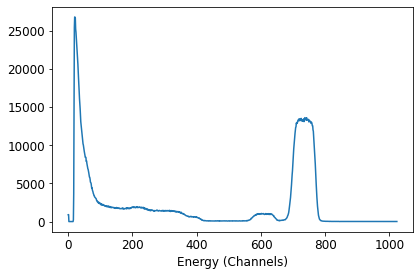

In [4]:
# load file
idf_file = IDF(file_path_ori)

# print a summary of the IDF contents
idf_file.print_idf_file()

## Setting the simulation models

In Example 1, we only paid attention to the experimental data. Thus, the IDF current state has no information on the models and NDF run options. To define them we can either load the **IDFViewer** (as in [Example A2](../Example_a2/IDFViewer_pyIBA.ipynb)) or do it manually as shown next:

In [5]:
idf_file.set_model_pileup('Wielopolski and Gardner (WG - slow)', '')
idf_file.set_model_doublescatter('Fast', 1)
idf_file.set_model_energyloss('SRIM 2003 (SR03)')
idf_file.set_model_straggling('Chu Model', 1)

idf_file.set_NDF_run_option('fitmethod', '3 - ')
idf_file.set_NDF_run_option('channelcompreesion', '0 - No compression')
idf_file.set_NDF_run_option('convolute', '1 - Convolute FWHM')
idf_file.set_NDF_run_option('distribution', '0 - Don\'t use isotropic distribution')
idf_file.set_NDF_run_option('smooth', '1 - Smooth data')
idf_file.set_NDF_run_option('normalisation', '1 - Normalise profile')

## If the technique is not RBS, you need to also add it
# idf_file.set_technique('RBS')

idf_file.save_idf(file_path_changed);

>**Note**: Remember to save the IDF object into the disk so that the file NDF can load the updated file. If not saved, NDF won't see the changes and the original file is run instead.

So now we can run NDF on our IDF object using the imported `pyIBA.codes.IDF`. A terminal windows should open.

In [6]:
run_ndf(idf_file)

Opening NDF...
wine /home/msequeira/Dropbox/CTN/Radiate/IDF_python/GUI/pyIBA-0.1.0/pyIBA/codes/NDF_11_MS/NDF.exe idf_example3.xml 3 0 1 0 1 1


## Loading and inspecting the results

The results can be loaded while the NDF is still running (obviously not the final ones). For that, we do the following:

In [7]:
idf_file.append_simulation_entry(1)
idf_file.set_spectra_result()
idf_file.set_elements_result()
idf_file.set_profile_result()

To plot the experimental and fitted spectra, we do as in the previous examples:

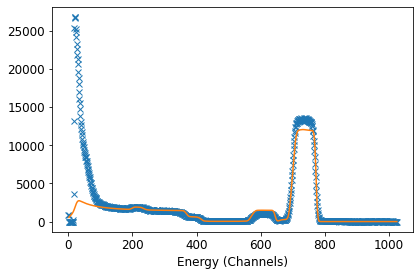

In [8]:
fig, ax = plt.subplots(1, 1)

xx, yy = idf_file.get_dataxy()
xx_fit, yy_fit = idf_file.get_dataxy_fit()

ax.plot(xx, yy, 'x')
ax.plot(xx_fit, yy_fit)
ax.set_xlabel('Energy (Channels)')
fig.tight_layout()

It turns out, our first try was not so good. To inspect the related profile, we can run:

In [9]:
profile_results = idf_file.get_profile_fit_result()
profile_results

{'nlayers': '5',
 0: {'thickness': '300.0', 'concentrations': ['97.07', '2.93', '0.0']},
 1: {'thickness': '126.289', 'concentrations': ['96.1', '0.16', '3.74']},
 2: {'thickness': '97.966', 'concentrations': ['37.907', '32.319', '29.774']},
 3: {'thickness': '475.517', 'concentrations': ['0.809', '96.105', '3.086']},
 4: {'thickness': '3671.05', 'concentrations': ['0.0', '0.0', '100.0']},
 'names': ['Co 1 Pt 1', 'Si 1 O 2', 'Si']}

## Making some changes and rerunning NDF

From the figure above, we realize that one of the reasons for the observed divergence between the fit and the experimental data is that we kept the stoichiometry of the top layer of CoPt constant. Therefore, we the next step will be to change the stoichiometry for an approximated CoPt$_2$ and let NDF change this value (by introducing the familiar '?='). 
  
This is changed in the *elements* part of IDF file. To load this part and print the returning dictionary we do:

In [10]:
elements = idf_file.get_elements()
elements

{'nelements': 3,
 0: {'name': 'Co 1 Pt 1',
  'density': '',
  'concentration': ['0', '1'],
  'depth': ['0', '1000']},
 1: {'name': 'Si 1 O 2',
  'density': '',
  'concentration': ['0', '1'],
  'depth': ['0', '1000']},
 2: {'name': 'Si',
  'density': '',
  'concentration': ['0', '1'],
  'depth': ['300', '1e6']}}

or, to simple show the CoPt entry (the *0* element):

In [11]:
elements[0]

{'name': 'Co 1 Pt 1',
 'density': '',
 'concentration': ['0', '1'],
 'depth': ['0', '1000']}

To change the formula of the CoPt, we do:

In [12]:
elements[0]['name'] = 'Co ?=0.36 Pt ?=0.64'

Finally, to change on the IDF object and afterwards on the IDF file:

In [13]:
# set the updated elements dictionary
idf_file.set_elements(elements)

# save the object to the file
idf_file.save_idf(file_path_changed);

And rerun the NDF:

In [14]:
run_ndf(idf_file)

Opening NDF...
wine /home/msequeira/Dropbox/CTN/Radiate/IDF_python/GUI/pyIBA-0.1.0/pyIBA/codes/NDF_11_MS/NDF.exe idf_example3.xml 3 0 1 0 1 1


To load the results into the IDF file and check then here we do as before (in fact, since we are reusing so much this part of the code we should have made a function for it at the beginning):

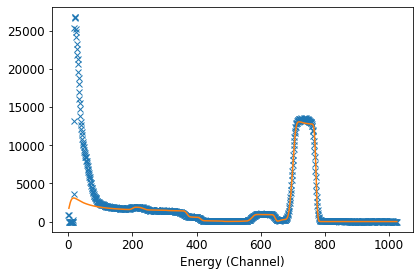

In [15]:
idf_file.set_spectra_result()
idf_file.set_elements_result()
idf_file.set_profile_result()

plt.figure()

xx, yy = idf_file.get_dataxy()
xx_fit, yy_fit = idf_file.get_dataxy_fit()

plt.plot(xx, yy, 'x')
plt.plot(xx_fit, yy_fit)
plt.xlabel('Energy (Channel)')
plt.tight_layout()

Much better, despite with still room to improve. This is left to the enthusiastic reader of this tutorial.
  
To check the new stoichiometry:

In [16]:
elements_results = idf_file.get_elements_fit_result()
elements_results

{'nelements': '3',
 0: 'Co 0.362357 Pt 0.637643',
 1: 'Si 0.3333 O 0.6667',
 2: 'Si'}

As expected, the stoichiometry is indeed different than the expected one. To check the profile:

In [17]:
idf_file.get_profile_fit_result()

{'nlayers': '7',
 0: {'thickness': '300.0', 'concentrations': ['76.697', '23.303', '0.0']},
 1: {'thickness': '0.0', 'concentrations': ['84.086', '8.071', '7.843']},
 2: {'thickness': '167.852', 'concentrations': ['78.992', '17.866', '3.143']},
 3: {'thickness': '6.729', 'concentrations': ['35.454', '37.44', '27.106']},
 4: {'thickness': '102.975', 'concentrations': ['19.972', '54.652', '25.376']},
 5: {'thickness': '422.444', 'concentrations': ['0.655', '99.345', '0.0']},
 6: {'thickness': '11534.0', 'concentrations': ['0.0', '0.0', '100.0']},
 'names': ['Co 0.36 Pt 0.64', 'Si 1 O 2', 'Si']}

The important layers are the *0, 5* and *6*. The remaining ones are a bit unrealistic.

Before trying something else, lets first save this state to another file:

In [18]:
file_path_changed_14 = 'idf_example3-14.xml'

idf_file.save_idf(file_path_changed_14);

## Changing the models and the run options

Lets try now a quick local search since we might have already some idea of what is going on. it appears that NDF wants to put some extra Si in the transition layer between CoPt and SiO$_2$. So we change the depth at which Si and SiO$_2$ can exist:

In [19]:
for i in range(elements['nelements']):
    elements[i]['name'] = elements_results[i]
    
elements[2]['depth'] = [0, 1e6]
elements[1]['depth'] = [500, 1000]

elements

{'nelements': 3,
 0: {'name': 'Co 0.362357 Pt 0.637643',
  'density': '',
  'concentration': ['0', '1'],
  'depth': ['0', '1000']},
 1: {'name': 'Si 0.3333 O 0.6667',
  'density': '',
  'concentration': ['0', '1'],
  'depth': [500, 1000]},
 2: {'name': 'Si',
  'density': '',
  'concentration': ['0', '1'],
  'depth': [0, 1000000.0]}}

We also change the profile so that it includes 5% of Si on the top layer:

In [20]:
profile = idf_file.get_profile()
profile[0]['concentrations'] = [95, 0, 5]
profile[0]['thickness'] = 500

profile

{'nlayers': 2,
 'names': ['Co ?=0.36 Pt ?=0.64', 'Si 1 O 2', 'Si'],
 0: {'thickness': 500, 'concentrations': [95, 0, 5]},
 1: {'thickness': '550', 'concentrations': ['0', '100', '0']},
 2: {'thickness': '4000000', 'concentrations': ['0', '0', '100']}}

We also change the Double Scattering model to *Normal* and set the fitting method to the local search (*x* in the NDF terminology):

In [21]:
idf_file.set_model_doublescatter('Normal', 1)

idf_file.set_NDF_run_option('fitmethod', 'x - ')

We add the updated elements and the profile to the IDF object and save it:

In [22]:
idf_file.set_elements(elements)
idf_file.set_profile(profile)

idf_file.save_idf(file_path_changed);

And run NDF again

In [23]:
run_ndf(idf_file)

Opening NDF...
wine /home/msequeira/Dropbox/CTN/Radiate/IDF_python/GUI/pyIBA-0.1.0/pyIBA/codes/NDF_11_MS/NDF.exe idf_example3.xml x 0 1 0 1 1


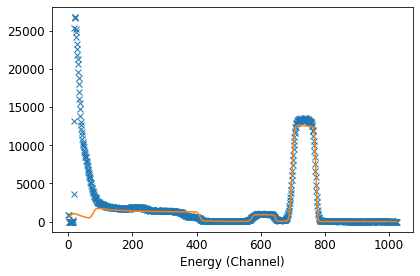

In [24]:
idf_file.set_spectra_result()
idf_file.set_elements_result()
idf_file.set_profile_result()

plt.figure()

xx, yy = idf_file.get_dataxy()
xx_fit, yy_fit = idf_file.get_dataxy_fit()

plt.plot(xx, yy, 'x')
plt.plot(xx_fit, yy_fit)
plt.xlabel('Energy (Channel)')
plt.tight_layout()

In [25]:
idf_file.get_elements_fit_result()

{'nelements': '3', 0: 'Co 0.3624 Pt 0.6376', 1: 'Si 0.3333 O 0.6667', 2: 'Si'}

In [26]:
idf_file.get_profile_fit_result()

{'nlayers': '2',
 0: {'thickness': '460.41', 'concentrations': ['93.71', '0.0', '6.29']},
 1: {'thickness': '3482.21', 'concentrations': ['0.0', '0.0', '100.0']},
 'names': ['Co 0.362357 Pt 0.637643', 'Si 0.3333 O 0.6667', 'Si']}

Not so good after all...

# Fitting multiple spectra in the same IDF

We now focus on a more interesting symbiosis between **pyIBA** and **NDF**: **Multi-fitting**
  
To exemplify this, we will:
1. add another RBS spectrum to the IDF file used above obtained from the same sample but with a different incident angle;
2. run NDF on this IDF file in two configurations:
    - multi-fitting using both spectra;
    - fit each single spectrum independently (i.e. in batch mode).
    
We start with the IDF file saved in point in section [Making Some Changes](../Example_a3/running_ndf.ipynb#Making-some-changes-and-rerunning-NDF):

In [27]:
# load previous IDF
idf_file = IDF(file_path_changed_14)
 
# set path to new spectrum data
file2_path = 'RBS2PT50CO50_5.odf'

As done in [Example 4](../../Example4/muitple_spectra_IDF.ipynb#4---Adding-multiple-spectra-to-a-single-IDF-file), we 
1. append another spectrum entry to the IDF object;
2. add the data to this new entry by setting `spectra_id = 1`;
3. copy the parameters from the first spectrum to the new one by using `unify_geo_parameters()`;
4. change the incident angle of the second spectra using `set_incident_angle(5, spectra_id = 1)`;
5. check and save the new IDF.

=============== idf_example3 ===============
idf_example3.xml
Miguel Sequeira 

------------------  Notes  ------------------
This file was created during Example 1, it relates to a RBS measurement of a CoPt/SiO2 sample.
Something I did after the first note

------------------ Elements -----------------
nelements 	 3

 - - - Element 0 - - -
name 		 Co ?=0.36 Pt ?=0.64
density  	 
concentration  	 ['0', '1']
depth 		 ['0', '1000']

 - - - Element 1 - - -
name 		 Si 1 O 2
density  	 
concentration  	 ['0', '1']
depth 		 ['0', '1000']

 - - - Element 2 - - -
name 		 Si
density  	 
concentration  	 ['0', '1']
depth 		 ['300', '1e6']

------------------ Profile -----------------
nlayers 		 2
names 		 ['Co ?=0.36 Pt ?=0.64', 'Si 1 O 2', 'Si']

 - - - Layer 0 - - -
thickness 		 390
concentrations  	 ['100', '0', '0']

 - - - Layer 1 - - -
thickness 		 550
concentrations  	 ['0', '100', '0']

 - - - Layer 2 - - -
thickness 		 4000000
concentrations  	 ['0', '0', '100']



-------- Spectrum 0 (

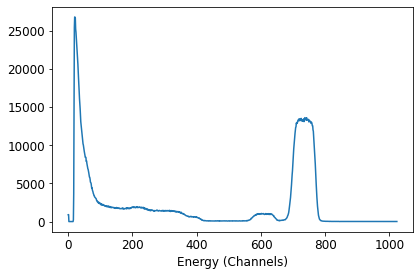

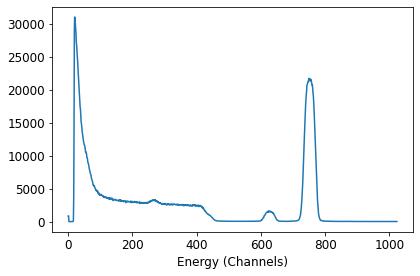

In [28]:
# append entry
idf_file.append_spectrum_entry(2)
# add spectrum data
idf_file.set_spectrum_data_from_file(file2_path, spectra_id=1)
# copy parameters from spectrum 0 to spectrum 1
idf_file.unify_geo_parameters()

# change incident angle of spectrum 1
idf_file.set_incident_angle(5, spectra_id=1)

# save and check
idf_file.save_idf(file_path_changed)
idf_file.print_idf_file()

## Multi-fitting

We can now performing a multi-fit by simply running:

In [29]:
run_ndf(idf_file)

Opening NDF...
wine /home/msequeira/Dropbox/CTN/Radiate/IDF_python/GUI/pyIBA-0.1.0/pyIBA/codes/NDF_11_MS/NDF.exe idf_example3.xml 3 0 1 0 1 1


To check the results, we do as before:

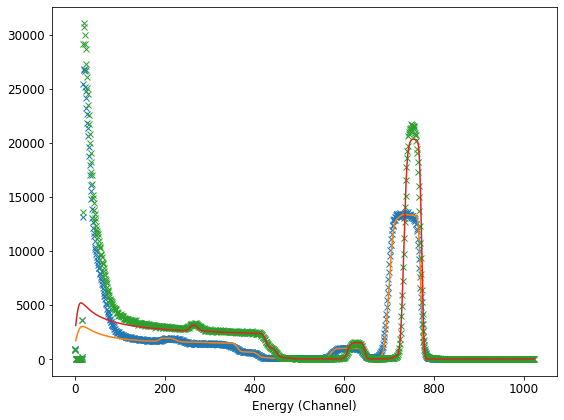

In [30]:
# the load the changes made by NDF (in fact by IDF2NDF) 
idf_file = IDF(file_path_changed)

plt.figure(figsize=((8,6)))

# loop through each spectrum and plot the experimental and best fit data
for i in range(idf_file.get_number_of_spectra()):
    idf_file.set_spectra_result(spectra_id = i)
    idf_file.set_elements_result(spectra_id = i)
    idf_file.set_profile_result(spectra_id = i)
    
    xx, yy = idf_file.get_dataxy(spectra_id = i)
    xx_fit, yy_fit = idf_file.get_dataxy_fit(spectra_id = i)

    plt.plot(xx, yy, 'x')
    plt.plot(xx_fit, yy_fit)
plt.xlabel('Energy (Channel)')
plt.tight_layout()

Check the elements and profile that result in the best fit:

In [31]:
idf_file.get_elements_fit_result()

{'nelements': '3',
 0: 'Co 0.374253 Pt 0.625747',
 1: 'Si 0.3333 O 0.6667',
 2: 'Si'}

In [32]:
idf_file.get_profile_fit_result()

{'nlayers': '5',
 0: {'thickness': '310.95', 'concentrations': ['78.93', '21.07', '0.0']},
 1: {'thickness': '130.496', 'concentrations': ['74.8', '16.279', '8.922']},
 2: {'thickness': '92.809', 'concentrations': ['23.848', '44.792', '31.359']},
 3: {'thickness': '464.601', 'concentrations': ['0.467', '95.68', '3.853']},
 4: {'thickness': '33813.9', 'concentrations': ['0.0', '0.0', '100.0']},
 'names': ['Co 0.36 Pt 0.64', 'Si 1 O 2', 'Si']}

## Independently

To fit the two spectra independently, we need to first associated them to different simulations groups using `set_simulation_group()`:

In [33]:
idf_file.set_simulation_group(0, spectra_id=0)
idf_file.set_simulation_group(1, spectra_id=1)

idf_file.save_idf(file_path_changed);

Note that you can associate several spectra to the same simulation group. A multi-fitting procedure will be run on each simulation group. For instance, if the IDF contains 3 spectra and we separate them as follows:

```python
#spectrum 0 goes to group 0
idf_file.set_simulation_group(0, spectra_id=0)

#spectra 1 and 2 go to group 1
idf_file.set_simulation_group(1, spectra_id=1)    
idf_file.set_simulation_group(1, spectra_id=2)
```

NDF will first analyse spectrum 0 alone and them spectra 1 and 2 simultaneously (i.e. multi-fit).

Returning to our IDF with two spectra:

In [34]:
run_ndf(idf_file)

Opening NDF...
wine /home/msequeira/Dropbox/CTN/Radiate/IDF_python/GUI/pyIBA-0.1.0/pyIBA/codes/NDF_11_MS/NDF.exe idf_example3.xml 3 0 1 0 1 1


To load the results:

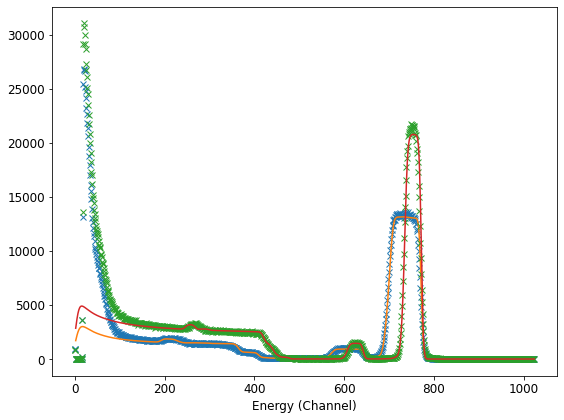

In [35]:
# the load the changes made by NDF (in fact by IDF2NDF)
# in particular to load the output file name codes that are
# stored in the IDF
idf_file = IDF(file_path_changed)
plt.figure(figsize=(8,6))

for i in range(idf_file.get_number_of_spectra()):
    idf_file.set_spectra_result(spectra_id = i)
    idf_file.set_elements_result(spectra_id = i)
    idf_file.set_profile_result(spectra_id = i)
    
    xx, yy = idf_file.get_dataxy(spectra_id = i)
    xx_fit, yy_fit = idf_file.get_dataxy_fit(spectra_id = i)

    plt.plot(xx, yy, 'x')
    plt.plot(xx_fit, yy_fit)
plt.xlabel('Energy (Channel)')
plt.tight_layout()

In [36]:
idf_file.get_elements_fit_result()

{'nelements': '3',
 0: 'Co 0.359183 Pt 0.640817',
 1: 'Si 0.3333 O 0.6667',
 2: 'Si'}

In [37]:
idf_file.get_profile_fit_result()

{'nlayers': '6',
 0: {'thickness': '300.0', 'concentrations': ['79.935', '20.065', '0.0']},
 1: {'thickness': '153.088', 'concentrations': ['80.884', '9.363', '9.754']},
 2: {'thickness': '95.677', 'concentrations': ['18.443', '49.532', '32.024']},
 3: {'thickness': '46.994', 'concentrations': ['6.603', '91.718', '1.68']},
 4: {'thickness': '403.214', 'concentrations': ['0.571', '95.325', '4.104']},
 5: {'thickness': '55257.1', 'concentrations': ['0.0', '0.0', '100.0']},
 'names': ['Co 0.36 Pt 0.64', 'Si 1 O 2', 'Si']}